# 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Initialize Global Variables and Helper Functions

In [5]:
SEQUENCE_LENGTH = 12
MODEL_DIR = 'clove_models'

#create model directory if it does not exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation Functions

In [6]:
def load_and_prepare_data(data_path):
    """Load and prepare the clove price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders: 
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'inflation_Rate']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    rolling_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'inflation_Rate']
    for col in rolling_columns:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [9]:
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv'
df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()
df.info()

Loading data from C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv...
Initial data shape: (1470, 17)
Columns: ['Month', 'Grade', 'Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (1470, 78)
Unique grades: ['Clove' 'Stem']
Unique regions: ['Badulla' 'Colombo' 'Galle' 'Gampaha' 'Hambantota' 'Kalutara' 'Kandy'
 'Kegalle' 'Kurunegala' 'Matale' 'Matara' 'Monaragala' 'Nuwaraeliya'
 'Ratnapura']

Data loaded successfully!
Shape: (1470, 78)

First few rows:
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 5 to 1465
Data columns (total 78 columns):
 #   Column                              Non-Null Count  Dtyp

# 5. Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

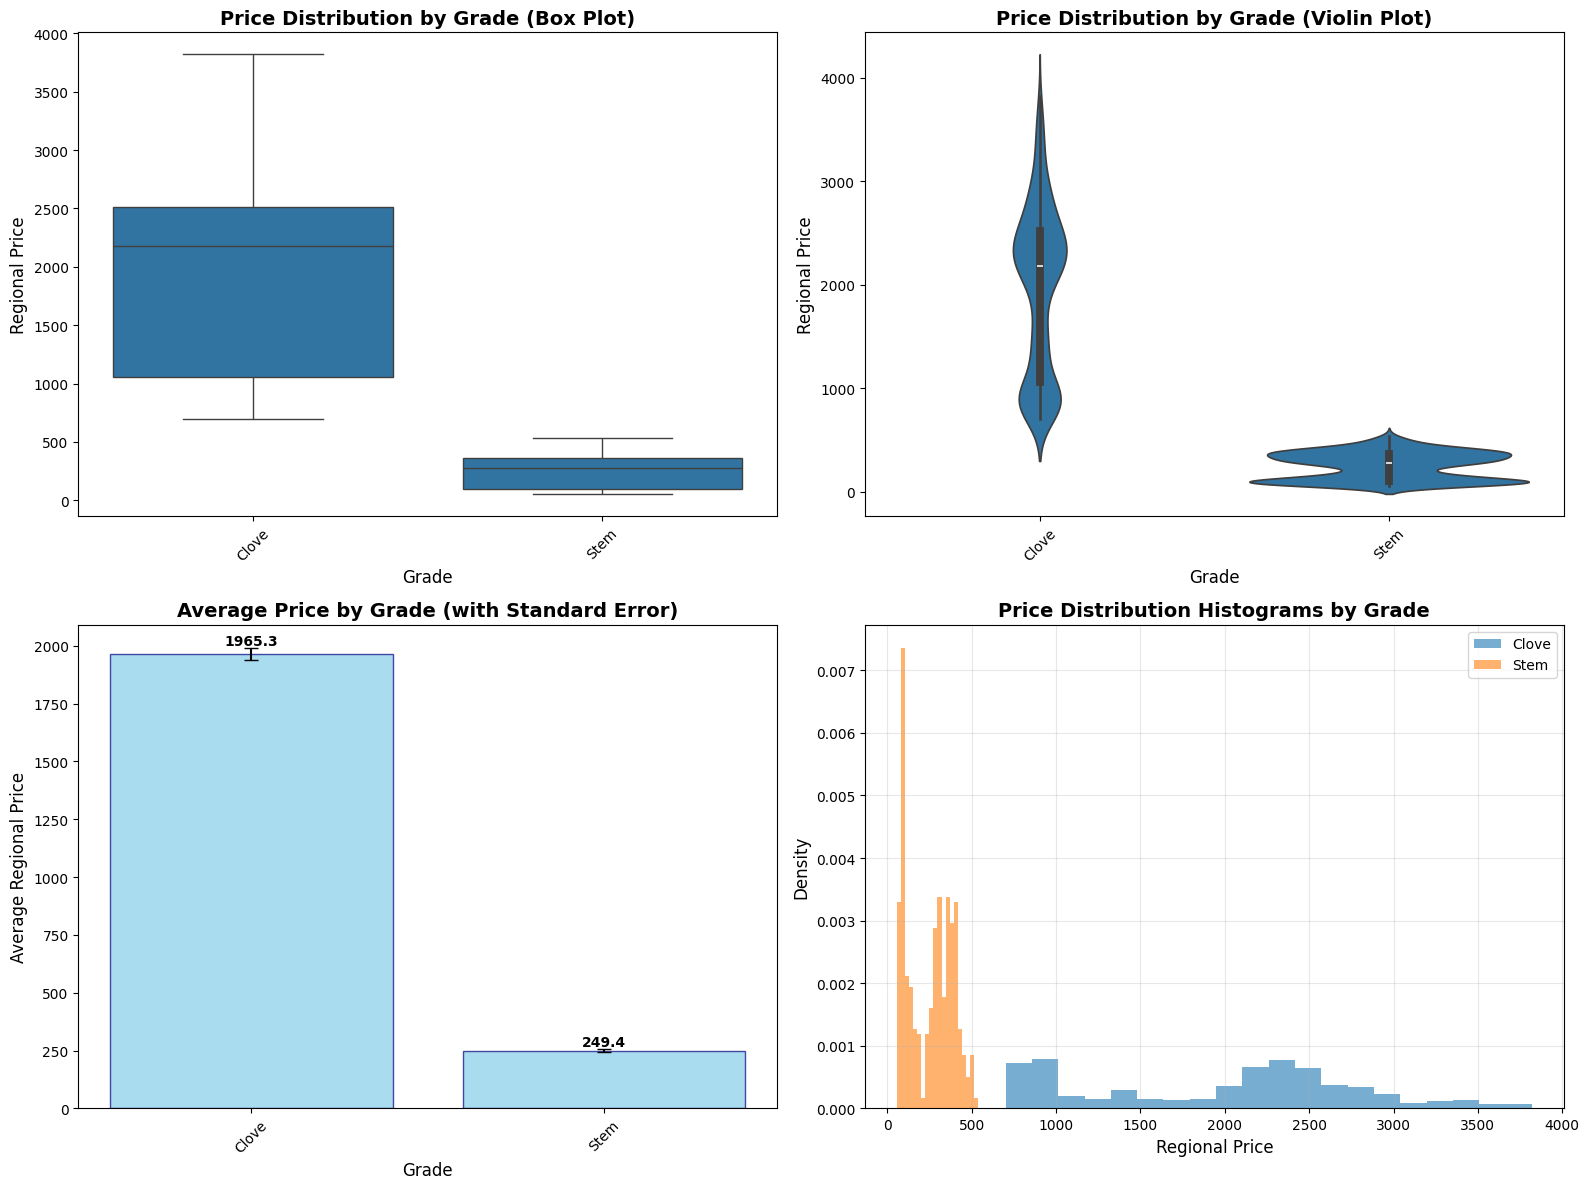


Price Distribution Summary by Grade:
       count     mean     std    min      25%      50%      75%     max
Grade                                                                  
Clove  980.0  1965.32  801.88  700.0  1058.83  2181.62  2514.50  3821.0
Stem   490.0   249.43  133.09   55.0   100.81   279.00   365.75   537.5


In [8]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

# 6. Feature Correlation Matrix

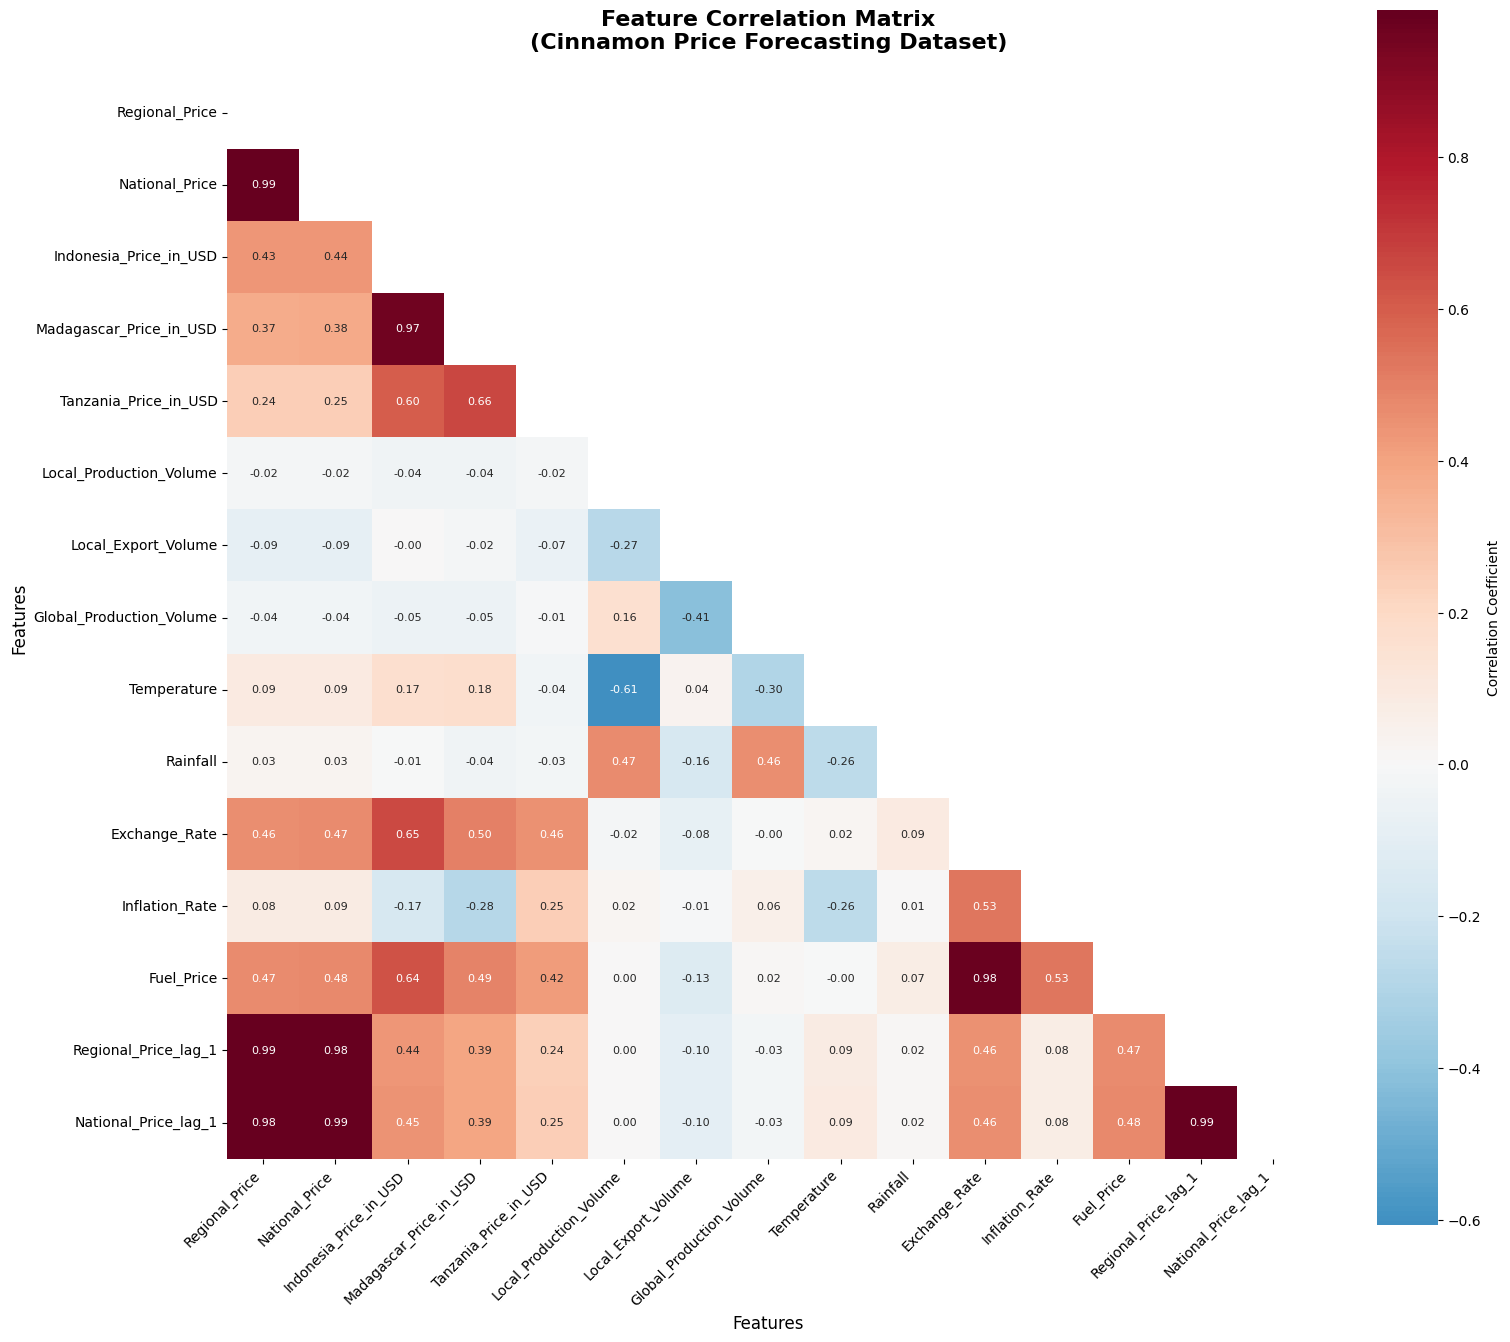


Highly Correlated Feature Pairs (|correlation| > 0.7):
National_Price ↔ National_Price_lag_1: 0.995
Regional_Price ↔ Regional_Price_lag_1: 0.991
Regional_Price ↔ National_Price: 0.989
Regional_Price_lag_1 ↔ National_Price_lag_1: 0.989
Regional_Price ↔ National_Price_lag_1: 0.984
National_Price ↔ Regional_Price_lag_1: 0.984
Exchange_Rate ↔ Fuel_Price: 0.980
Indonesia_Price_in_USD ↔ Madagascar_Price_in_USD: 0.969


In [10]:
def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
    'Regional_Price', 
    'National_Price', 
    'Indonesia_Price_in_USD', 
    'Madagascar_Price_in_USD', 
    'Tanzania_Price_in_USD',
    'Local_Production_Volume',
    'Local_Export_Volume',
    'Global_Production_Volume',
    'Temperature', 
    'Rainfall', 
    'Exchange_Rate', 
    'Inflation_Rate',
    'Fuel_Price',
    'Regional_Price_lag_1',
    'National_Price_lag_1'
]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

# 7. Sequence Preparation Function for LSTM

In [11]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Instead of dropping all NaNs, fill them
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print("Total sequences created:", len(X_sequences))
    return np.array(X_sequences), np.array(y_sequences), metadata

# 8. LSTM Model Building with Hyperparameter Tuning

In [12]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model with various hyperparameters"""
    model = Sequential()
    
    # Choose layer type
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:  # SimpleRNN
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # SGD
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 9. Define Tuner Class

In [13]:
class HyperparameterTuner:
    """Hyperparameter tuning class using multiple strategies"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def grid_search_tuning(self, param_grid=None, max_trials=20):
        """Grid search hyperparameter tuning"""
        print("\n🔍 Starting Grid Search Hyperparameter Tuning...")
        print("=" * 60)
        
        if param_grid is None:
            param_grid = {
                'units1': [64, 128, 256, 512, 1024],
                'units2': [32, 64, 128, 256, 512],
                'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dense_units': [16, 32, 64, 128, 256],
                'learning_rate': [0.001, 0.0005, 0.002, 0.005, 0.01],
                'layer_type': ['LSTM', 'GRU'],
                'use_batch_norm': [True, False]
            }
        
        # Generate all combinations and sample randomly if too many
        param_combinations = list(product(*param_grid.values()))
        if len(param_combinations) > max_trials:
            param_combinations = np.random.choice(
                param_combinations, size=max_trials, replace=False
            )
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        best_val_loss = float('inf')
        best_params = None
        
        for i, params in enumerate(param_combinations[:max_trials]):
            param_dict = dict(zip(param_grid.keys(), params))
            
            try:
                print(f"\nTrial {i+1}/{min(len(param_combinations), max_trials)}: {param_dict}")
                
                # Build and train model
                model = build_lstm_model_tunable(**param_dict, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': param_dict.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = param_dict.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Grid Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        # Plot optimization history
        self.plot_optuna_results(study)
        
        return study.best_params, study.best_value
    
    def plot_optuna_results(self, study):
        """Plot Optuna optimization results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot optimization history
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        ax1.plot(values, marker='o', alpha=0.7)
        ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importance
        if len(study.trials) > 10:
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())
                importances = list(importance.values())
                
                ax2.barh(params, importances)
                ax2.set_title('Parameter Importance', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Importance')
                ax2.grid(True, alpha=0.3)
            except:
                ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes)
        
        # Plot best value progression
        best_values = []
        current_best = float('inf')
        for trial in study.trials:
            if trial.value is not None and trial.value < current_best:
                current_best = trial.value
            best_values.append(current_best)
        
        ax3.plot(best_values, marker='o', alpha=0.7, color='green')
        ax3.set_title('Best Value Progression', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Trial')
        ax3.set_ylabel('Best Validation Loss')
        ax3.grid(True, alpha=0.3)
        
        # Distribution of validation losses
        ax4.hist(values, bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
        ax4.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Validation Loss')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            # Randomly sample hyperparameters
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': np.random.loguniform(1e-4, 1e-2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}: {params}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_results:
            print("No tuning results to plot.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Extract data
        trials = [r['trial'] for r in self.tuning_results]
        val_losses = [r['val_loss'] for r in self.tuning_results]
        val_maes = [r['val_mae'] for r in self.tuning_results]
        
        # Plot validation loss progression
        ax1.plot(trials, val_losses, marker='o', alpha=0.7)
        ax1.set_title('Validation Loss by Trial', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot validation MAE progression
        ax2.plot(trials, val_maes, marker='s', alpha=0.7, color='orange')
        ax2.set_title('Validation MAE by Trial', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Validation MAE')
        ax2.grid(True, alpha=0.3)
        
        # Histogram of validation losses
        ax3.hist(val_losses, bins=15, alpha=0.7, edgecolor='black')
        ax3.axvline(self.best_score, color='red', linestyle='--', 
                   label=f'Best: {self.best_score:.6f}')
        ax3.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Validation Loss')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Best value progression
        best_so_far = []
        current_best = float('inf')
        for loss in val_losses:
            if loss < current_best:
                current_best = loss
            best_so_far.append(current_best)
        
        ax4.plot(trials, best_so_far, marker='o', alpha=0.7, color='green')
        ax4.set_title('Best Validation Loss Progression', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Trial')
        ax4.set_ylabel('Best Validation Loss')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# 10. Perform Hyperparameter Tuning

In [14]:
def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna', 'grid', or 'random'")
    
    # Plot results
    if method in ['grid', 'random']:
        tuner.plot_tuning_results()
    
    return best_params, best_score, tuner

# 11. LSTM Model Building Function

In [15]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters from tuning"""
    if best_params is None:
        # Default parameters
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)

# 12. Training History Visualization Function

In [16]:
def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

# 13. Model Training Function

In [17]:

def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model with best parameters
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    # Print model summary
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    
    # Use longer training for final model
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create comprehensive results dictionary
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    # Add tuning results if available
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results